## Overview


In this exercise, we are training an autoencoder to detect anomalies on the CSV dataset.

## Load data and mandate libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [2]:
# Download the dataset
dataframe = pd.read_csv('anomaly_detection_data_extended.csv')
raw_data = dataframe.values
dataframe.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Label
0,-1.443855,-2.296181,-0.550537,-1.220712,-0.508140,0
1,-0.147780,-0.453248,1.452468,0.326745,0.300474,0
2,0.622207,-1.138833,1.039112,-0.075764,0.670481,0
3,-1.071857,-1.553759,0.817890,0.376410,-0.902052,0
4,-0.869663,1.125435,-1.189412,1.642673,-0.900621,0


In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  1050 non-null   float64
 1   Feature2  1050 non-null   float64
 2   Feature3  1050 non-null   float64
 3   Feature4  1050 non-null   float64
 4   Feature5  1050 non-null   float64
 5   Label     1050 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 49.3 KB


Data has no missing values.

In [4]:

dataframe['Label'].value_counts()

0    1000
1      50
Name: Label, dtype: int64

Since we are using this data for anomaly detection, the class labeled as 1 (with 50 instances) would likely represent the anomalous or fraudulent cases, while class 0 (with 1000 instances) would represent normal or non-anomalous cases.



In [5]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=4
)

Normalize both train_data and test_data using these computed min-max values, ensuring all data values are scaled between 0 and 1, and then cast them to tf.float32 for consistency in data type.

In [7]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

we will train the autoencoder using only the normal rhythms, which are labeled in this dataset as 0. Separate the normal rhythms from the abnormal rhythms.

In [8]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

In [9]:
print(normal_test_data.shape)

(203, 5)


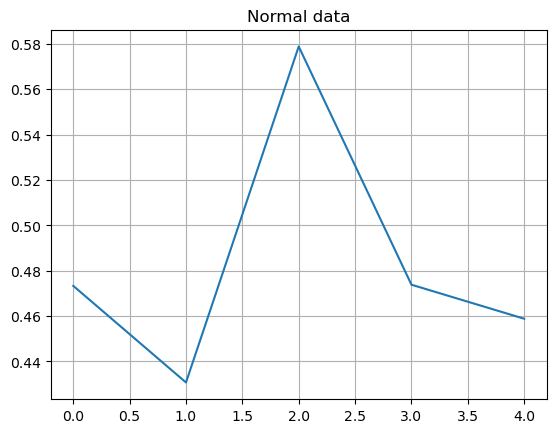

In [10]:
plt.grid()
plt.plot(np.arange(5), normal_train_data[0])
plt.title("Normal data")
plt.show()

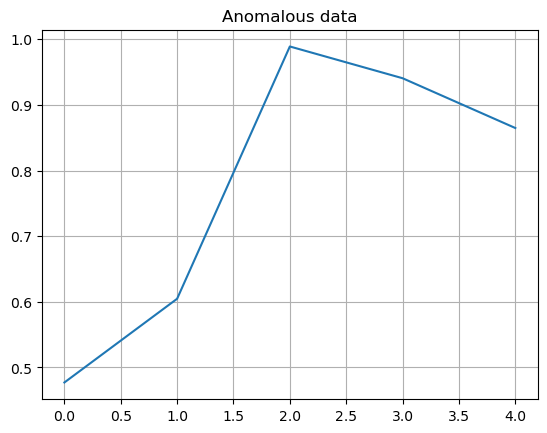

In [11]:
plt.grid()
plt.plot(np.arange(5), anomalous_train_data[0])
plt.title("Anomalous data")
plt.show()

Specifying the Adam optimizer with a learning rate of 0.001 (learning_rate), which controls how the model adjusts its weights during training to minimize the loss function i.e mae.

In [13]:
# Define the optimizer with the desired learning rate
learning_rate = 0.001  # New learning rate value
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
autoencoder.compile(optimizer='adam', loss='mae')

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(8, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(4, activation="relu")
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(8, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(16, activation="relu"),
            layers.BatchNormalization(),
            layers.Dense(5, activation="sigmoid")  # Adjust output dimension to match input
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


# Initialize the model
autoencoder = AnomalyDetector()

# Compile the model
autoencoder.compile(optimizer, loss='mae')

# Print model summary
autoencoder.summary()


Model: "anomaly_detector_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

 We will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data.

In [15]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=500, 
          batch_size=16,
          validation_data=(test_data, test_data),
          shuffle=True)


Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0663 - val_loss: 0.0744
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0677 - val_loss: 0.0741
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0661 - val_loss: 0.0733
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0655 - val_loss: 0.0708
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0620 - val_loss: 0.0682
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0609 - val_loss: 0.0675
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0600 - val_loss: 0.0669
Epoch 8/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0594 - val_loss: 0.0681
Epoch 9/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0587 - val_loss: 0.0667
Epoch 10/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0595 - val_loss: 0.0665
Epoch 11/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0593 - val_loss: 0.0669
Epoch 12/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0541 - val_loss: 0.0610
Epoch 70/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0538 - val_loss: 0.0626
Epoch 71/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0559 - val_loss: 0.0619
Epoch 72/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0560 - val_loss: 0.0621
Epoch 73/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0562 - val_loss: 0.0612
Epoch 74/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0558 - val_loss: 0.0611
Epoch 75/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0554 - val_loss: 0.0622
Epoch 76/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0556 - val_loss: 0.0613
Epoch 77/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0549 - val_loss: 0.0618
Epoch 78/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0554 - val_loss: 0.0612
Epoch 79/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0540 - val_loss: 0.0611
Epoch 80/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0533 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0552 - val_loss: 0.0616
Epoch 138/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0547 - val_loss: 0.0609
Epoch 139/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0550 - val_loss: 0.0610
Epoch 140/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0549 - val_loss: 0.0614
Epoch 141/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0537 - val_loss: 0.0610
Epoch 142/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0542 - val_loss: 0.0611
Epoch 143/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0554 - val_loss: 0.0610
Epoch 144/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0538 - val_loss: 0.0617
Epoch 145/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0547 - val_loss: 0.0615
Epoch 146/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0545 - val_loss: 0.0612
Epoch 147/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0549 - val_loss: 0.0610
Epoch 148/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0541 - val_loss: 0.0610
Epoch 205/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0539 - val_loss: 0.0611
Epoch 206/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0558 - val_loss: 0.0613
Epoch 207/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0555 - val_loss: 0.0612
Epoch 208/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0553 - val_loss: 0.0625
Epoch 209/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0558 - val_loss: 0.0610
Epoch 210/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0539 - val_loss: 0.0609
Epoch 211/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0549 - val_loss: 0.0611
Epoch 212/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0561 - val_loss: 0.0612
Epoch 213/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0550 - val_loss: 0.0609
Epoch 214/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0546 - val_loss: 0.0613
Epoch 215/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0541 - val_loss: 0.0616
Epoch 272/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0558 - val_loss: 0.0611
Epoch 273/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0560 - val_loss: 0.0619
Epoch 274/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0555 - val_loss: 0.0613
Epoch 275/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0542 - val_loss: 0.0611
Epoch 276/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0553 - val_loss: 0.0612
Epoch 277/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0539 - val_loss: 0.0616
Epoch 278/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0553 - val_loss: 0.0610
Epoch 279/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0529 - val_loss: 0.0614
Epoch 280/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0554 - val_loss: 0.0609
Epoch 281/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0543 - val_loss: 0.0610
Epoch 282/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0538 - val_loss: 0.0611
Epoch 339/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0558 - val_loss: 0.0609
Epoch 340/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0539 - val_loss: 0.0609
Epoch 341/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0558 - val_loss: 0.0610
Epoch 342/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0552 - val_loss: 0.0609
Epoch 343/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0540 - val_loss: 0.0619
Epoch 344/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0543 - val_loss: 0.0611
Epoch 345/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0560 - val_loss: 0.0609
Epoch 346/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0530 - val_loss: 0.0613
Epoch 347/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0545 - val_loss: 0.0613
Epoch 348/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0544 - val_loss: 0.0611
Epoch 349/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0550 - val_loss: 0.0612
Epoch 406/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0542 - val_loss: 0.0609
Epoch 407/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0542 - val_loss: 0.0615
Epoch 408/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0545 - val_loss: 0.0609
Epoch 409/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0555 - val_loss: 0.0611
Epoch 410/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0549 - val_loss: 0.0609
Epoch 411/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0545 - val_loss: 0.0609
Epoch 412/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0550 - val_loss: 0.0609
Epoch 413/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0549 - val_loss: 0.0613
Epoch 414/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0548 - val_loss: 0.0610
Epoch 415/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0537 - val_loss: 0.0610
Epoch 416/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - lo

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0466 - val_loss: 0.0536
Epoch 473/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0468 - val_loss: 0.0533
Epoch 474/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0454 - val_loss: 0.0534
Epoch 475/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0477 - val_loss: 0.0531
Epoch 476/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0473 - val_loss: 0.0535
Epoch 477/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0469 - val_loss: 0.0534
Epoch 478/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0459 - val_loss: 0.0531
Epoch 479/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0469 - val_loss: 0.0532
Epoch 480/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0465 - val_loss: 0.0536
Epoch 481/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0461 - val_loss: 0.0531
Epoch 482/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0454 - val_loss: 0.0531
Epoch 483/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

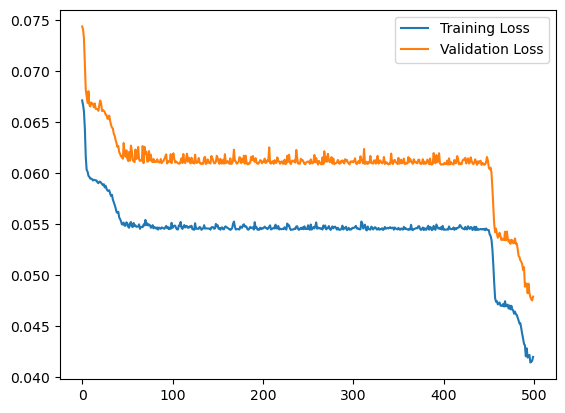

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

 First, let's plot a normal data from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

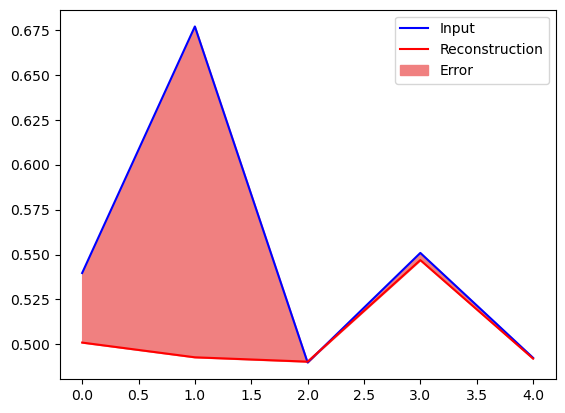

In [17]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(5), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

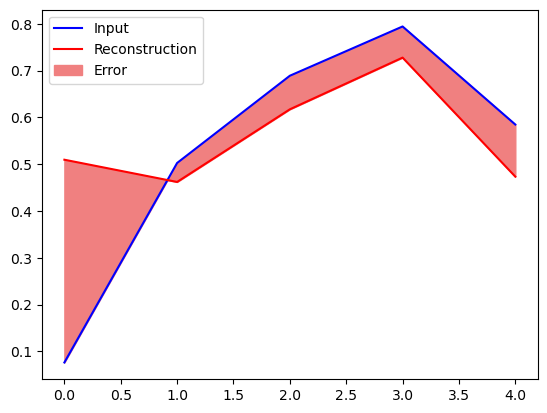

In [18]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(5), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Classify as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples.

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


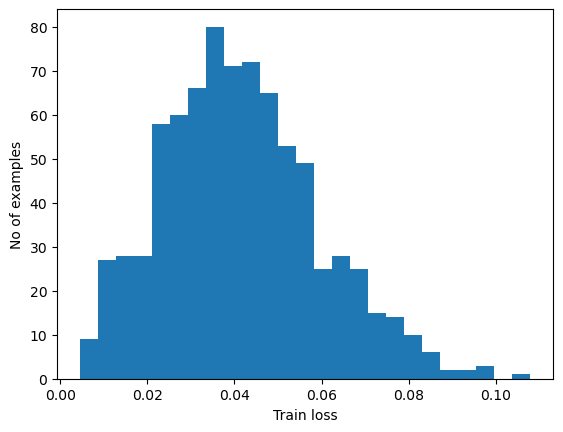

In [19]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=25)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [20]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.059326693


 Our hypothesis is that the abnormal rhythms will have higher reconstruction error. we will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


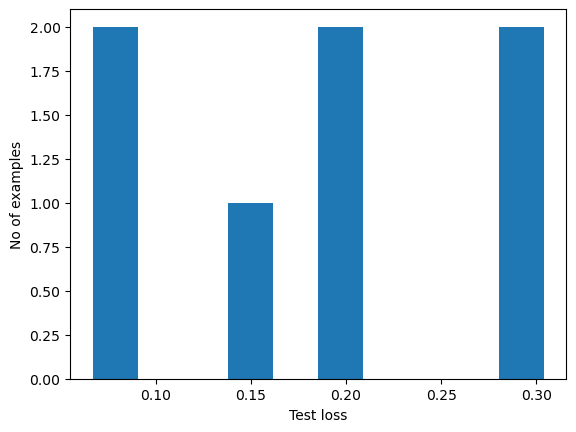

In [21]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=10)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [22]:
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    binary_predictions = loss > threshold
    return binary_predictions.numpy(), loss.numpy()

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))
    print("F1 Score = {}".format(f1_score(labels, predictions)))

def plot_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [23]:
sum(test_labels)

7

Accuracy = 0.8380952380952381
Precision = 0.17073170731707318
Recall = 1.0
F1 Score = 0.2916666666666667


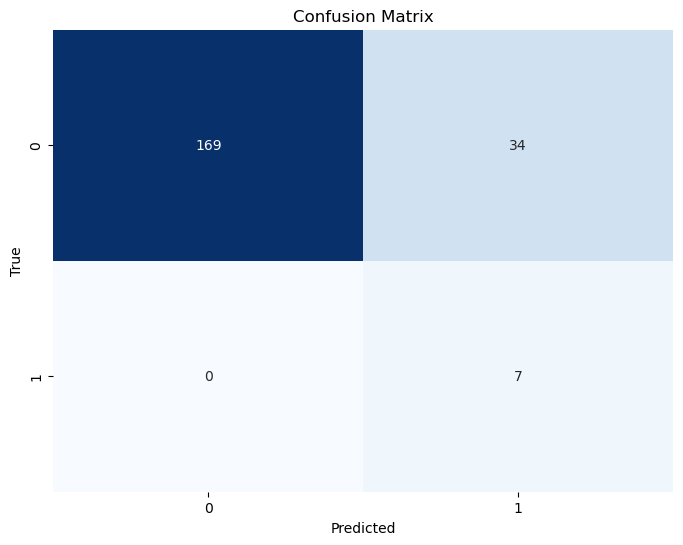

In [24]:
predictions, losses = predict(autoencoder,test_data, threshold)

# Print statistics
print_stats(predictions, test_labels)

# Plot confusion matrix
plot_confusion_matrix(test_labels, predictions)



### Overall Performance:

The model achieves relatively high accuracy (83.8%), which suggests that a large proportion of predictions are correct across both classes (normal and anomalous).
However, precision is low (17.1%), indicating that when the model predicts an instance as anomalous, it is correct only 17.1% of the time. This suggests a high number of false positives.

### Recall and Anomaly Detection:

Recall is 100%, indicating that the model correctly identifies all true positive anomalies (fraudulent cases in this context). This implies that the model is sensitive enough to capture all instances of the anomalous class.

In conclusion, while the model shows strong recall in identifying anomalies, addressing the imbalance and improving precision are key areas to enhance the overall effectiveness of anomaly detection systems in practical applications.
